In [2]:
import xml.etree.ElementTree as et
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Załadownie plików xml, wstępna obróbka danych, załadowanie do ramek pandas

In [3]:
file_adress = 'movies.stackexchange.com/'
file_list = ['Badges.xml', 'Comments.xml','PostHistory.xml',\
             'PostLinks.xml','Posts.xml','Tags.xml','Users.xml','Votes.xml']
file_paths = []
for file in file_list:
    file_path = file_adress+file
    file_paths.append(file_path)

In [4]:
def create_dataframe(file_path):
    e = et.parse(file_path).getroot()
    columns = []
    for key in e[0].attrib:
        columns.append(key)
    elems = []
    for elem in e:
        elems.append(elem.attrib)
    df = pd.DataFrame(elems, columns=(columns))
    return df

In [5]:
def create_dataframes(file_paths):
    d = {}
    for path in file_paths:
        df_name = path[25:-4].lower()
        d[df_name] = create_dataframe(path)
    return d

In [6]:
df_dict = create_dataframes(file_paths)

In [7]:
def change_data_type():
    for key,value in df_dict.items():
        columns = value.columns
        for elem in columns:
            if 'Date' in elem:
                value[elem] = pd.to_datetime(value[elem])
            elif 'Count' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int32)
            elif 'Id' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int32)
            elif 'Votes' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int16)
            elif 'Score' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int16)
            elif 'Reputation' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int32)
            elif 'Views' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int32)
            elif 'Class' in elem:
                value.loc[:,elem].fillna('-1',inplace=True)
                value[elem] = value[elem].astype(np.int16)

In [8]:
change_data_type()

In [ ]:
#zapis dataframes do csv

for key,value in df_dict.items():
    csv_name = key+'.csv'
    value.to_csv(csv_name)

In [ ]:
badges = df_dict['badges']
posthistory =  df_dict['posthistory']
users =  df_dict['users']
postlinks =  df_dict['postlinks']
tags =  df_dict['tags']
votes =  df_dict['votes']
posts =  df_dict['posts']
comments =  df_dict['comments']

### Stworzenie bazy SQL (SQLite)

In [ ]:
conn = sqlite3.connect("movies.sqlite")

In [ ]:
badges.to_sql('badges', conn)
posthistory.to_sql('posthistory', conn)
users.to_sql('users', conn)
postlinks.to_sql('postlinks', conn)
tags.to_sql('tags', conn)
votes.to_sql('votes', conn)
posts.to_sql('posts', conn)
comments.to_sql('comments', conn)

## Pytania, zagadnienia dotyczące forum

In [15]:
# 1. 10 najczęściej poruszanych zagadnień na forum
pd.read_sql_query("""
select most_popular.count, p.Title from posts p
join
(select RelatedPostId, count(Id) as count from postlinks
group by RelatedPostId
order by count(Id) desc
limit 10) as most_popular
on p.Id = most_popular.RelatedPostId
order by count desc
""", conn)

,count,Title
0,115,How can I find tv shows/films similar to one I...
1,24,How to identify a movie from a screen shot?
2,19,How could the human race be saved in Interstel...
3,18,What rules govern how TV show opening credits ...
4,15,At which dream level did Inception end?
5,13,Boy sent to a mental asylum for teenagers wher...
6,13,Was film actually “better” than digital media?
7,12,What happened to Charles Xavier after X-Men 3?
8,11,To what extent are child actors exposed to the...
9,11,Where can I find scripts/screenplays/transcrip...


In [16]:
#2 Top 10 użytkowników forum z najlepszym poziomem akceptowania odpowiedzi.
pd.read_sql_query("""
select tbl.OwnerUserId, count(tbl.OwnerUserId) as count, u.DisplayName from users u
join
(select p1.AcceptedAnswerId, p2.OwnerUserId from posts p1
join posts p2
on p1.AcceptedAnswerId = p2.Id) as tbl
on tbl.OwnerUserId = u.Id and tbl.OwnerUserId <> -1
group by tbl.OwnerUserId
order by count desc
limit 10
""", conn)

,tbl.OwnerUserId,count,u.DisplayName
0,34317,559,Paulie_D
1,4386,453,Walt
2,23541,368,cde
3,1190,298,Ankit Sharma
4,8219,296,Andrew Martin
5,49,191,Napoleon Wilson
6,8071,187,Johnny Bones
7,1525,168,Oliver_C
8,13595,155,BCdotWEB
9,27264,150,A J


In [18]:
#3 Jaki jest średni procent akceptowania odpowiedzi spośród wszystkich odpowiedzi
#  udzielanych dla każdego użytkownika? 

acc_answers_from_user = posts.merge(posts, left_on='AcceptedAnswerId', right_on='Id').\
query('OwnerUserId_y != -1').groupby(['OwnerUserId_y']).size().to_frame().\
rename(columns={0:'count'}).reset_index()

all_answers_from_user = posts.query('PostTypeId == 2 & OwnerUserId != -1').\
groupby(['OwnerUserId']).size().to_frame().\
rename(columns={0:'count'}).reset_index()

result_table_avg = all_answers_from_user.merge(acc_answers_from_user, left_on='OwnerUserId',\
                                    right_on='OwnerUserId_y',how='left')
result_table_avg.loc[:,'count_y'].fillna(0, inplace=True)
result_table_avg['mean']=result_table_avg.count_y/result_table_avg.count_x
result_table_avg['mean'].mean()


0.14092817881279548

In [19]:
#3.b Top 10 użytkowników z największym procentem zaakceptowanych odpowiedzi
#   (dla użytkowników z conajmniej 50 odpowiedziami) 

result_table = all_answers_from_user.merge(acc_answers_from_user, left_on='OwnerUserId',\
                                           right_on='OwnerUserId_y')
result_table['avg_acceptance_rate'] = result_table.count_y/result_table.count_x
result_table = result_table.query('count_x>=50').\
sort_values(['avg_acceptance_rate'], ascending=False)

final_table = result_table.merge(users, left_on='OwnerUserId', right_on='Id').\
loc[:,('DisplayName','count_x','count_y','avg_acceptance_rate')]
final_table.head(10)

,DisplayName,count_x,count_y,avg_acceptance_rate
0,Walt,569,453,0.796134
1,Oliver_C,219,168,0.767123
2,Chanandler Bong,103,71,0.689320
3,Nobby,188,129,0.686170
4,djmadscribbler,50,34,0.680000
5,Tablemaker,130,87,0.669231
6,Crow T Robot,87,58,0.666667
7,coleopterist,105,68,0.647619
8,MJ6,157,100,0.636943
9,System Down,189,120,0.634921


In [24]:
#4 Liczba pytań w ostatnich 12 miesiącach z rozbiciem na 30-dniowe zakresy + wizualizacja
posts['month'] = posts['CreationDate'].dt.to_period('m')
post_count = posts[(posts.CreationDate>='2017-12-01 00:00:00.000') & \
      (posts.CreationDate <'2018-12-01 00:00:00.000')].query('PostTypeId == 1').\
groupby('month').size().rename('count').to_frame()
post_count

,count
month,
2017-12,280
2018-01,249
2018-02,215
2018-03,199
2018-04,242
2018-05,290
2018-06,183
2018-07,163
2018-08,152


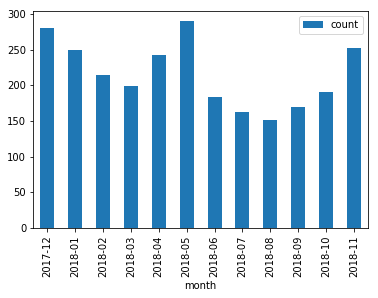

In [25]:
post_count.plot(kind='bar')

In [26]:
#5 Liczba odpowiedzi w ostatnich 12 miesiącach z rozbiciem na 30-dniowe zakresy + wizualizacja
posts['month'] = posts['CreationDate'].dt.to_period('m')
post_count = posts[(posts.CreationDate>='2017-12-01 00:00:00.000') & \
      (posts.CreationDate <'2018-12-01 00:00:00.000')].query('PostTypeId == 2').\
groupby('month').size().rename('count').to_frame()
post_count

,count
month,
2017-12,447
2018-01,372
2018-02,325
2018-03,294
2018-04,335
2018-05,434
2018-06,248
2018-07,236
2018-08,254


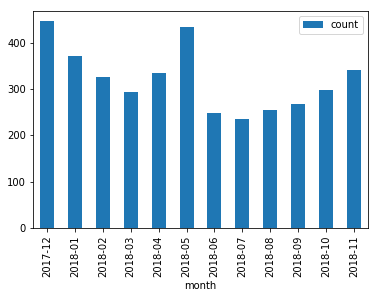

In [27]:
post_count.plot(kind='bar')

In [28]:
#6 top 10 użytkowników wg najlepszego wyniku reputacja/dzień
# a) liczba dni od pierwszego do ostatniego posta dla użytkowników mających
#    conajmniej 10 postów

user_posts_date = users.merge(posts, left_on='Id', right_on='OwnerUserId')
user_posts_date2 = user_posts_date.query('Id_x != -1').\
    groupby(['Id_x','DisplayName','Reputation'])['CreationDate_y'].\
    agg(["min", "max", "count"]).reset_index()
user_posts_date2['days_first_to_last_post'] = \
    (user_posts_date2['max']-user_posts_date2['min']).dt.days
user_posts_date2['rep_days'] = user_posts_date2['Reputation']/user_posts_date2['days_first_to_last_post']

user_posts_date2.query('days_first_to_last_post != 0 & count >= 10').\
    sort_values('rep_days', ascending=False).head(10)

,Id_x,DisplayName,Reputation,min,max,count,days_first_to_last_post,rep_days
11,26,Lauren,2332,2011-11-30 20:08:23.267,2011-12-06 21:53:52.297,10,6,388.666667
8162,42940,akr,523,2016-11-07 21:34:38.537,2016-11-10 04:01:16.040,13,2,261.500000
1302,4761,FredH,5999,2013-05-02 23:02:02.107,2013-07-03 15:31:27.367,41,61,98.344262
6864,34317,Paulie_D,81180,2016-06-26 11:23:13.780,2018-11-30 12:46:08.773,981,887,91.521984
6736,33629,Alexandre,1279,2016-04-25 14:48:23.733,2016-05-11 15:35:59.753,14,16,79.937500
4979,23541,cde,57716,2015-06-28 18:46:02.737,2017-07-21 13:27:48.437,872,753,76.648074
2170,7732,rumandwrite,4056,2014-01-23 10:24:42.653,2014-03-23 08:59:14.387,25,58,69.931034
2280,8219,Andrew Martin,46076,2014-02-25 15:07:21.637,2016-04-22 10:40:08.877,492,786,58.620865
1193,4386,Walt,91895,2013-03-18 21:08:12.487,2017-10-29 22:23:55.530,569,1686,54.504745
7688,40325,whirlaway,416,2016-08-21 13:21:18.723,2016-08-30 12:15:12.277,11,8,52.000000


In [29]:
#6 top 10 użytkowników wg najlepszego wyniku reputacja/dzień
# b) poziom reputacji aktualny -> podzielić na liczbę dni

users['days_on_forum'] = (datetime.datetime.now() - users['CreationDate']).dt.days
users['rep_days'] = users['Reputation']/users['days_on_forum']

top_reputation = users.loc[:,('DisplayName','Reputation','days_on_forum','rep_days')].\
sort_values('rep_days', ascending=False)
top_reputation.head(10)

,DisplayName,Reputation,days_on_forum,rep_days
20212,Paulie_D,81180,1042,77.907869
13694,cde,57716,1324,43.592145
2846,Walt,91895,2190,41.961187
15578,A J,39631,1236,32.063916
1102,Ankit Sharma,69930,2522,27.727994
5649,Andrew Martin,46076,1847,24.946400
5545,Johnny Bones,37485,1857,20.185784
1388,Oliver_C,41914,2464,17.010552
35971,Darth Locke,9257,569,16.268893
4257,John Smith Optional,31997,1994,16.046640


In [30]:
# 7 10 najbardziej popularnych tagów, które utworzyli użytkownicy
popular_tags = pd.read_sql_query("""
select TagName, Count from tags
order by count desc
limit 10
""", conn)
popular_tags

,TagName,Count
0,plot-explanation,6088
1,character,1869
2,analysis,1159
3,identify-this-movie,861
4,marvel-cinematic-universe,803
5,dialogue,626
6,game-of-thrones,567
7,production,530
8,film-techniques,469
9,star-wars,323


In [32]:
#8 dla znalezionych 10 najpopularniejszych tagów prześledzić historię wzrostu liczby postów
#  a) Utworzenie serii danych z liczbą postów z tagiem w dniu x, x+1...

posts['Tags_filled'] = posts['Tags'].fillna('<>')
tag_name = []
tag_date = []
for tag in popular_tags['TagName']:
    for index, row in posts.iterrows():
        if tag in row['Tags_filled']:
            tag_name.append(tag)
            tag_date.append(row['CreationDate'])

d = {'tagName': tag_name, 'tagDate': tag_date}
tags_time = pd.DataFrame(d)
tags_time['Year'] = tags_time['tagDate'].map(lambda x: x.year)
tags_time['Quarter'] = tags_time['tagDate'].dt.quarter

tags_time2 = tags_time.groupby(['tagName','Year','Quarter'])['tagName'].\
            size().rename('tag_count').to_frame().reset_index()
tags_time2 = pd.pivot_table(tags_time2, values='tag_count', index=['Year','Quarter'],\
                            columns='tagName').fillna(0)

tags_time2.head(10)

tagName       analysis  character  dialogue  film-techniques  game-of-thrones  \
Year Quarter                                                                    
2011 4            41.0       13.0       3.0              5.0              0.0   
2012 1            36.0       11.0      11.0             12.0              0.0   
     2            39.0       27.0       9.0             17.0              5.0   
     3            42.0       36.0       7.0              3.0              1.0   
     4            26.0       35.0       9.0              7.0              2.0   
2013 1            37.0       45.0       9.0             29.0              1.0   
     2            30.0       32.0       5.0              8.0             19.0   
     3            30.0       45.0       5.0              8.0             15.0   
     4            46.0       64.0      14.0             22.0              1.0   
2014 1            40.0       35.0      13.0             14.0              2.0   

tagName       identify-this-movie  marvel-cinematic-universe  \
Year Quarter                                                   
2011 4                       12.0                        1.0   
2012 1                       36.0                        1.0   
     2                       16.0                       21.0   
     3                       19.0                        2.0   
     4                       20.0                        5.0   
2013 1                       28.0                        5.0   
     2                       18.0                       13.0   
     3                       38.0                       11.0   
     4                       37.0                       17.0   
2014 1                       36.0                        9.0   

tagName       plot-explanation  production  star-wars  
Year Quarter                                           
2011 4                    60.0         2.0        4.0  
2012 1                   113.0         2.0        8.0  
     2                   139.0        11.0        3.0  
     3                   107.0         6.0        1.0  
     4                   179.0        10.0        3.0  
2013 1                   106.0        17.0        5.0  
     2                   112.0         6.0        8.0  
     3                   153.0        11.0        4.0  
     4                   162.0        15.0        2.0  
2014 1                   142.0        11.0        7.0

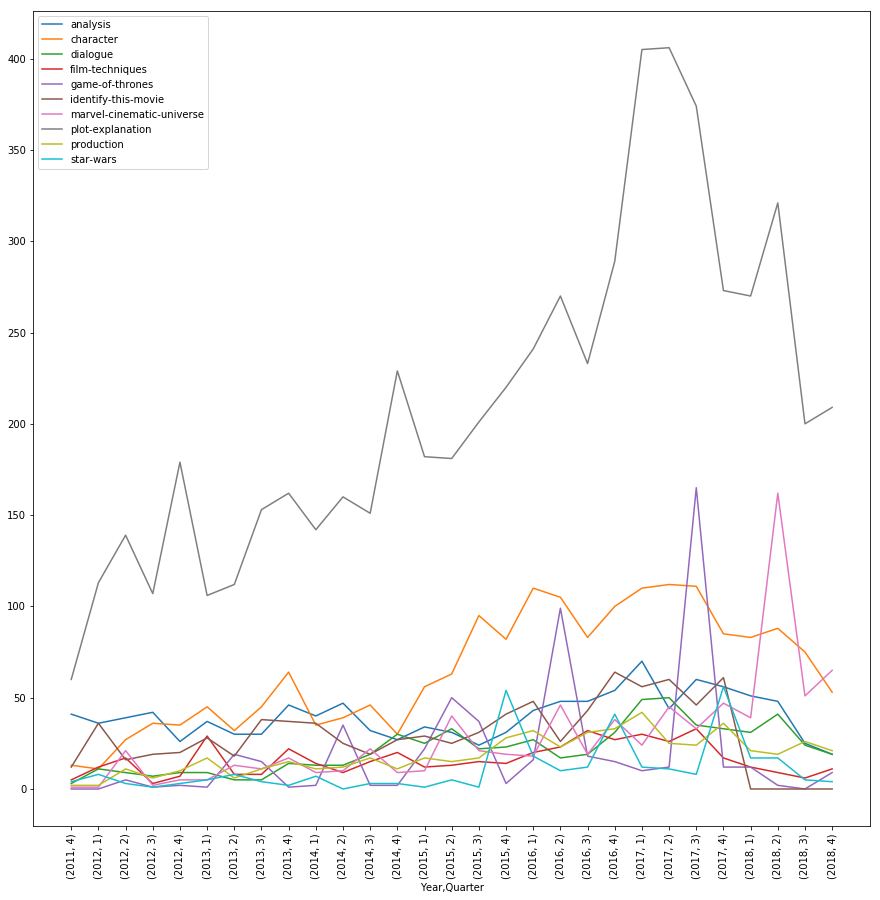

In [33]:
#8 dla znalezionych 10 najpopularniejszych tagów prześledzić historię wzrostu liczby postów
#  b) wizualizacja na jednym wykresie  - dla poszczególnych kwartałów (dla dni i miesięcy
#     wykres był bardzo nieczytelny) - nie umiem tu dodać etykiety osi x

fig = tags_time2.plot(figsize=(15,15))
plt.legend(tags_time2[1:])
plt.xticks(np.arange(0,29,1), rotation=90)
fig.set_xticklabels(labels=tags_time2.index)
plt.show(fig)


In [34]:
# 9 Filmy w których użytkownicy najczęściej proszą o wyjaśnienie fabuły
#  (tag='plot-explanation')

tags = []
tag = 'plot-explanation'
for index, row in posts.iterrows():
    if tag in row['Tags_filled']:
        tags.append(row['Tags_filled'])

movies = []
for elem in tags:
    elem = elem.split('><')
    elem[-1] = elem[-1][:-1] #tu zauważyłam, że tytuł filmu zawsze występuje jako ostatni tag w liście
    movies.append(elem[-1])
    
movies_df = pd.DataFrame(movies).rename(columns={0:'title'})
movies_df.groupby('title').size().rename('count').to_frame().reset_index().\
    sort_values('count',ascending=False).head(10)

,title,count
624,game-of-thrones,263
258,breaking-bad,102
1378,sherlock,81
154,avengers-infinity-war,81
787,interstellar,75
772,inception,51
1611,the-dark-knight-rises,39
1919,the-walking-dead,37
1651,the-flash,36
738,house-of-cards,33


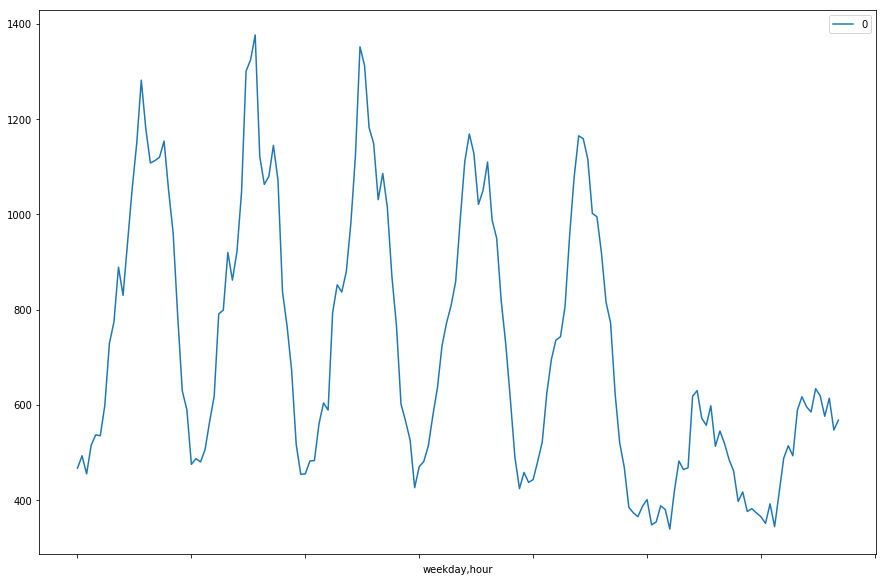

In [35]:
#10 a) Tygodniowy i godzinowy rozkład aktywności na forum (na podstawie daty tworzenia
#    postów i komentarzy)

dates = pd.read_sql_query("""
select posts.CreationDate from posts
where posts.CreationDate<'2018-12-01'
union all
select comments.CreationDate from comments
where comments.CreationDate<'2018-12-01'
""", conn)

dates['CreationDate'] = pd.to_datetime(dates['CreationDate'])
dates['weekday'] = dates['CreationDate'].dt.weekday
dates['hour'] = dates['CreationDate'].dt.hour

tbl = dates.groupby(['weekday','hour']).size().to_frame()
tbl.plot(figsize=(15,10))

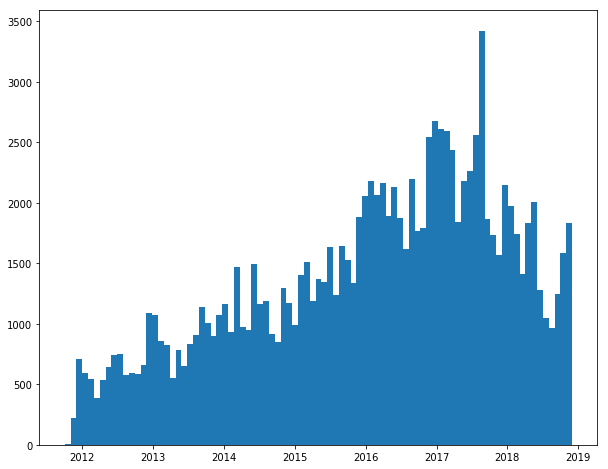

In [44]:
#10 b) Miesięczny rozkład aktywności od początku istnienia forum
plt.hist(dates['CreationDate'],\
         bins=int((dates['CreationDate'].max()-dates['CreationDate'].min()).days/30))
plt.rcParams['figure.figsize']=[15,10]
plt.show()